# LAB 3 
NAME: TAMOGHNA CHAKRABORTY
NetId: tc3142

# Installing essential packages

In [ ]:
%pip install tensorflow 

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install h5py

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Importing essential packages

In [ ]:
import h5py
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import warnings
from tqdm import tqdm

# Defining the file paths for data used

In [ ]:
clean_val_data_path = 'valid.h5'
clean_test_data_path= 'test.h5'
poisoned_val_data_path= 'bd_valid.h5'
poisoned_test_data_path= 'bd_test.h5'
model_path = 'sunglasses_bd_net.h5'

# classification accuracy of bd_net.h5 model and attack succes rate on it

In [ ]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

cl_x_test, cl_y_test = data_loader(clean_val_data_path)
bd_x_test, bd_y_test = data_loader(poisoned_val_data_path)

bd_model = keras.models.load_model(model_path)

cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy:', clean_accuracy)
    
bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate:', asr)



Clean Classification accuracy: 42.25339915129471
Attack Success Rate: 99.9047371611674


# Visualisation of clean data from validation set

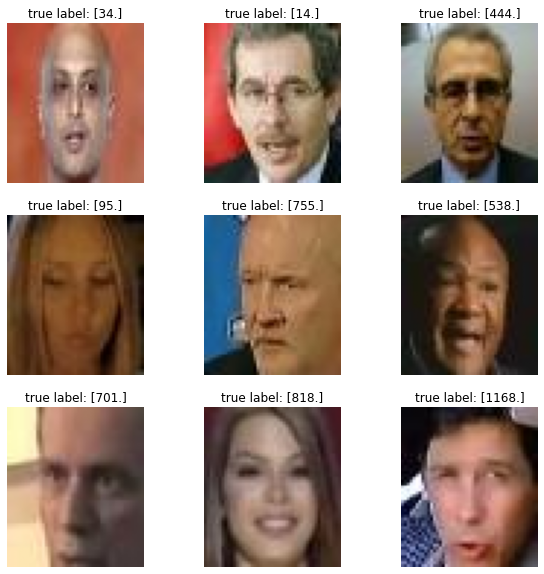

In [ ]:
x_data, y_data = data_loader(clean_val_data_path)

figure = plt.figure(figsize=(10,10))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

# Visualisation of poisoned data from validation set

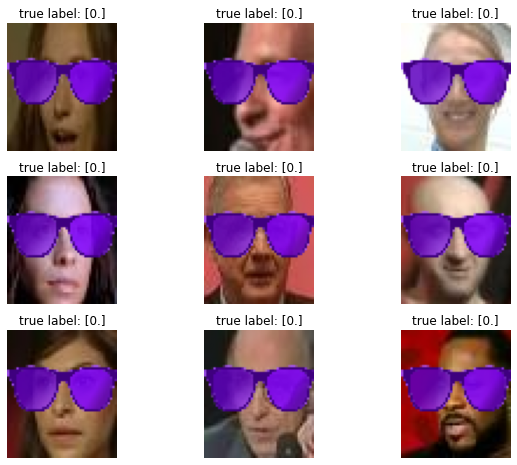

In [ ]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_val_data_path)

figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

# LET'S CHECK THE STRUCTURE OF THE MODEL NEXT. WILL HELP IN PRUNING

In [ ]:
model = keras.models.load_model(model_path) #bd_net model

In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

# According to the assignment, the last pooling layer, here pool_3 needs to be pruned by removing channels in increasing order of average activation values over the entire validation set.

In [ ]:
keras.backend.clear_session()

In [ ]:
cl_x_test, cl_y_test = data_loader(clean_val_data_path)
bd_x_test, bd_y_test = data_loader(poisoned_val_data_path)

In [ ]:
clean_data_acc_before = 42.25339915129471 #original classification accuracy
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights()) 
prune_index = []
clean_accuracy = [] #classification accuracy
asrate = []   #attack success rate
saved_model = np.zeros(3,dtype=bool)

# getting the activation from the last pooling layer
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)  
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq): 
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_acc_after = np.mean(np.equal(cl_label_p, cl_y_test))*100   #classification accuracy expressed in terms of %
  if (clean_data_acc_before-clean_acc_after >= 2 and not saved_model[0]): #difference >2%
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X_2.h5')
    saved_model[0] = 1
  if (clean_data_acc_before-clean_acc_after >= 4 and not saved_model[1]): #difference >4%
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X_4.h5')
    saved_model[1] = 1
  if (clean_data_acc_before-clean_acc_after >= 10 and not saved_model[2]): #difference >10%
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X_10.h5')
    saved_model[2] = 1
  clean_accuracy.append(clean_acc_after)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_acc_after)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()

  2%|▏         | 1/60 [00:06<05:59,  6.09s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0


  3%|▎         | 2/60 [00:12<05:49,  6.03s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26


  5%|▌         | 3/60 [00:18<05:43,  6.02s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27


  7%|▋         | 4/60 [00:24<05:37,  6.03s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30


  8%|▊         | 5/60 [00:30<05:31,  6.02s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31


 10%|█         | 6/60 [00:36<05:23,  5.99s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33


 12%|█▏        | 7/60 [00:42<05:18,  6.01s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34


 13%|█▎        | 8/60 [00:48<05:12,  6.01s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36


 15%|█▌        | 9/60 [00:54<05:05,  6.00s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37


 17%|█▋        | 10/60 [01:00<05:00,  6.01s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38


 18%|█▊        | 11/60 [01:06<04:54,  6.01s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25


 20%|██        | 12/60 [01:12<04:48,  6.00s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39


 22%|██▏       | 13/60 [01:18<04:43,  6.02s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41


 23%|██▎       | 14/60 [01:24<04:36,  6.01s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44


 25%|██▌       | 15/60 [01:30<04:29,  5.99s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45


 27%|██▋       | 16/60 [01:36<04:24,  6.01s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47


 28%|██▊       | 17/60 [01:42<04:18,  6.00s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48


 30%|███       | 18/60 [01:48<04:11,  5.99s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49


 32%|███▏      | 19/60 [01:54<04:06,  6.02s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50


 33%|███▎      | 20/60 [02:00<04:00,  6.01s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53


 35%|███▌      | 21/60 [02:06<03:54,  6.00s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55


 37%|███▋      | 22/60 [02:12<03:48,  6.02s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40


 38%|███▊      | 23/60 [02:18<03:42,  6.02s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24


 40%|████      | 24/60 [02:24<03:36,  6.02s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59


 42%|████▏     | 25/60 [02:30<03:31,  6.03s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9


 43%|████▎     | 26/60 [02:36<03:24,  6.02s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2


 45%|████▌     | 27/60 [02:42<03:18,  6.00s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12


 47%|████▋     | 28/60 [02:48<03:12,  6.03s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13


 48%|████▊     | 29/60 [02:54<03:06,  6.01s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17


 50%|█████     | 30/60 [03:00<03:00,  6.01s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14


 52%|█████▏    | 31/60 [03:06<02:54,  6.01s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15


 53%|█████▎    | 32/60 [03:12<02:48,  6.00s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23


 55%|█████▌    | 33/60 [03:18<02:41,  5.99s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6


 57%|█████▋    | 34/60 [03:24<02:35,  5.99s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51


 58%|█████▊    | 35/60 [03:30<02:29,  6.00s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32


 60%|██████    | 36/60 [03:36<02:23,  6.00s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22


 62%|██████▏   | 37/60 [03:42<02:18,  6.02s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21


 63%|██████▎   | 38/60 [03:48<02:12,  6.01s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20


 65%|██████▌   | 39/60 [03:54<02:06,  6.02s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19


 67%|██████▋   | 40/60 [04:00<02:00,  6.03s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43


 68%|██████▊   | 41/60 [04:06<01:54,  6.03s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58


 70%|███████   | 42/60 [04:12<01:47,  5.99s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3


 72%|███████▏  | 43/60 [04:18<01:42,  6.01s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42


 73%|███████▎  | 44/60 [04:24<01:36,  6.01s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1


 75%|███████▌  | 45/60 [04:30<01:29,  6.00s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29


 77%|███████▋  | 46/60 [04:36<01:24,  6.03s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16


 78%|███████▊  | 47/60 [04:42<01:18,  6.00s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56


 80%|████████  | 48/60 [04:48<01:11,  5.99s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46


 82%|████████▏ | 49/60 [04:54<01:06,  6.01s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5


 83%|████████▎ | 50/60 [05:00<00:59,  6.00s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8


 85%|████████▌ | 51/60 [05:06<00:53,  6.00s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11


 87%|████████▋ | 52/60 [05:12<00:48,  6.02s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54


 88%|████████▊ | 53/60 [05:18<00:42,  6.01s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10


 90%|█████████ | 54/60 [05:24<00:36,  6.00s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28
The accuracy drops at least 2%, saved the model
The accuracy drops at least 4%, saved the model
The accuracy drops at least 10%, saved the model


/home/tc3142/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
 92%|█████████▏| 55/60 [05:30<00:30,  6.02s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35


 93%|█████████▎| 56/60 [05:36<00:24,  6.01s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18


 95%|█████████▌| 57/60 [05:42<00:18,  6.00s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4


 97%|█████████▋| 58/60 [05:48<00:12,  6.04s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7


 98%|█████████▊| 59/60 [05:54<00:06,  6.03s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52


100%|██████████| 60/60 [06:00<00:00,  6.01s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


In [ ]:
print("clean_accuracy: ", clean_accuracy)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

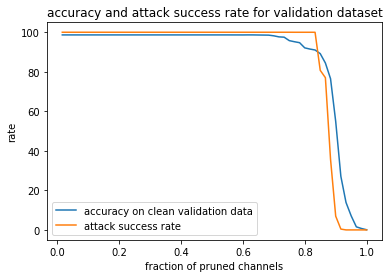

In [ ]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_accuracy)
plt.plot(x_axis,asrate)
plt.legend(['accuracy on clean validation data','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

# Reporting attack success rate for X=30%

In [ ]:
index = np.where(np.array(clean_accuracy) <= (clean_data_acc_before-30))[0]
print("The attack success rate when the accuracy drops at least 30% from original: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30% from original:  6.954187234779596


# Combining original badnet B and new badnet B' (after accuracy drops below X%, here x= {2,4,10})

In [ ]:
class Good(keras.Model):
  def __init__(self, Bad, Bad_prime):
      super(Good, self).__init__()
      self.Bad = Bad
      self.Bad_prime = Bad_prime

  def predict(self,data):
      y = np.argmax(self.Bad(data), axis=1)
      y_prime = np.argmax(self.Bad_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

In [ ]:
clean_test_data_path = 'test.h5'
poisoned_test_data_path = 'bd_test.h5'
test_model_X_2_path = 'model_X_2.h5'
test_model_X_4_path = 'model_X_4.h5'
test_model_X_10_path= 'model_X_10.h5'

# specifying paths for saved models (with accuracy drops of 2%,4% and 10%)

In [ ]:
test_model_X_2 = keras.models.load_model(test_model_X_2_path)
test_model_X_4 = keras.models.load_model(test_model_X_4_path)
test_model_X_10 = keras.models.load_model(test_model_X_10_path)

In [ ]:
x_test, y_test = data_loader(clean_test_data_path)
x_test_poisoned, y_test_poisoned = data_loader(poisoned_test_data_path)

# creating goodnet model G. If classification for both B and B' are same, the classification of G is also same, else it classifies to class 'n+1'

In [ ]:
Good_model_X_2 = Good(model, test_model_X_2)
Good_model_X_4 = Good(model, test_model_X_4)
Good_model_X_10 = Good(model, test_model_X_10)

# evaluating the B' models

In [ ]:
clean_test_2_label_p = np.argmax(test_model_X_2.predict(x_test), axis=1)
clean_test_2_accuracy = np.mean(np.equal(clean_test_2_label_p, y_test))*100
print('for model with 2% dropped , the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned), axis=1)
asrate_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisoned))*100
print('for model with 2% dropped , Attack Success Rate:', asrate_2)

clean_test_4_label_p = np.argmax(test_model_X_4.predict(x_test), axis=1)
clean_test_4_accuracy = np.mean(np.equal(clean_test_4_label_p, y_test))*100
print('for model with 4% dropped, the clean test data classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned), axis=1)
asrate_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisoned))*100
print('for model with 4% dropped, Attack Success Rate:', asrate_4)

clean_test_10_label_p = np.argmax(test_model_X_10.predict(x_test), axis=1)
clean_test_10_accuracy = np.mean(np.equal(clean_test_10_label_p, y_test))*100
print('for model with 10% dropped, the clean test data classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned), axis=1)
asrate_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisoned))*100
print('for model with 10% dropped, Attack Success Rate:', asrate_10)

for model with 2% dropped , the clean test data Classification accuracy: 95.90023382696803
for model with 2% dropped , Attack Success Rate: 100.0
for model with 4% dropped, the clean test data classification accuracy: 92.29150428682775
for model with 4% dropped, Attack Success Rate: 99.98441153546376
for model with 10% dropped, the clean test data classification accuracy: 84.54403741231489
for model with 10% dropped, Attack Success Rate: 77.20966484801247


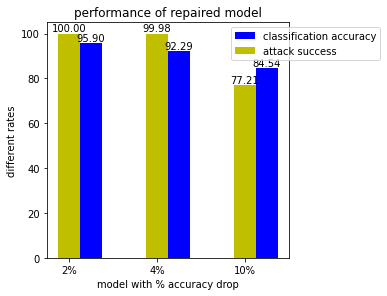

In [ ]:
test_accuracy = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_success_rates = [asrate_2, asrate_4, asrate_10]

opacity = 1
bar_width = 0.25

plt.xlabel('model with % accuracy drop')
plt.ylabel('different rates')

plt.xticks(range(len(test_accuracy)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_accuracy)) + bar_width, test_accuracy, bar_width, align='center', alpha=opacity, color='b', label='classification accuracy')
bar2 = plt.bar(range(len(attack_success_rates)), attack_success_rates, bar_width, align='center', alpha=opacity, color='y', label='attack success')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')

plt.show()

# evaluating G model. I calculated accuracy of this model based on whether the classification of the model and the other models are the same

In [ ]:
Good_clean_test_2_label_p = Good_model_X_2.predict(x_test)
Good_clean_test_2_accuracy = np.mean(np.equal(clean_test_2_label_p, y_test))*100
print('Combined model with 2% dropped acc, the clean test data classification accuracy:', Good_clean_test_2_accuracy)

Good_bd_test_2_label_p = Good_model_X_2.predict(x_test_poisoned)
Good_model_asrate_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisoned))*100
print('Combined model with 2% dropped acc, attack success Rate:', Good_model_asrate_2)

Good_clean_test_4_label_p = Good_model_X_4.predict(x_test)
Good_clean_test_4_accuracy = np.mean(np.equal(clean_test_4_label_p, y_test))*100
print('Combined model with 4% dropped acc, the clean test data classification accuracy:', Good_clean_test_4_accuracy)

Good_bd_test_4_label_p = Good_model_X_4.predict(x_test_poisoned)
Good_model_asrate_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisoned))*100
print('Combined model with 4% dropped acc, attack success Rate:', Good_model_asrate_4)

Good_clean_test_10_label_p = Good_model_X_10.predict(x_test)
Good_clean_test_10_accuracy = np.mean(np.equal(clean_test_10_label_p, y_test))*100
print('Combined model with 10% dropped acc, the clean test data classification accuracy:', Good_clean_test_10_accuracy)

Good_bd_test_10_label_p = Good_model_X_10.predict(x_test_poisoned)
Good_model_asrate_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisoned))*100
print('Combined model with 10% dropped acc, Attack Success Rate:', Good_model_asrate_10)

Combined model with 2% dropped acc, the clean test data classification accuracy: 95.90023382696803
Combined model with 2% dropped acc, attack success Rate: 100.0
Combined model with 4% dropped acc, the clean test data classification accuracy: 92.29150428682775
Combined model with 4% dropped acc, attack success Rate: 99.98441153546376
Combined model with 10% dropped acc, the clean test data classification accuracy: 84.54403741231489
Combined model with 10% dropped acc, Attack Success Rate: 77.20966484801247


# We see that pruning defense doesn't work very well for this model as the pruned model is not retrained with poisoned data.

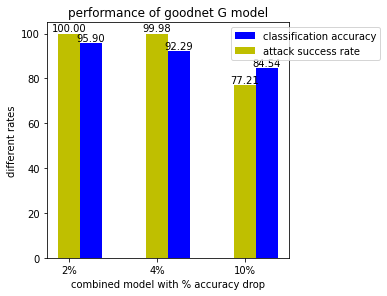

In [ ]:
good_model_test_accuracy= [Good_clean_test_2_accuracy, Good_clean_test_4_accuracy, Good_clean_test_10_accuracy]
Good_model_attack_success_rate = [Good_model_asrate_2, Good_model_asrate_4, Good_model_asrate_10]

opacity = 1
bar_width = 0.25

plt.xlabel('combined model with % accuracy drop')
plt.ylabel('different rates')

plt.xticks(range(len(good_model_test_accuracy)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(good_model_test_accuracy)) + bar_width, good_model_test_accuracy, bar_width, align='center', alpha=opacity, color='b', label='classification accuracy')
bar2 = plt.bar(range(len(Good_model_attack_success_rate)),Good_model_attack_success_rate, bar_width, align='center', alpha=opacity, color='y', label='attack success rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodnet G model')

plt.show()